# Alertness & REM‑Cue Pipeline v5 – Adjustable Lag, Transition‑Aware Cues
**Key upgrades**
1. Configurable lag parameters (`SMOOTH_WINDOW`, `STABLE_N`, `CHANGE_THRESH`).
2. Probability‑of‑change fed back into alertness smoothing (weighted EMA).
3. Continuous **CueGain** output: how loud to play REM audio (0–1).
4. Extra sanity metrics + plots for each subsystem.


In [ ]:

import os, pickle, warnings, math
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from scipy.signal import butter, filtfilt, welch
from scipy.stats import entropy as scipy_entropy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report,
                             roc_curve, auc, f1_score, precision_score, recall_score)
from sklearn.model_selection import GroupKFold, cross_val_score
import mne
sns.set(style='whitegrid'); warnings.filterwarnings('ignore')


In [84]:

DATA_ROOT = Path('sample_data')
FS = 125; EPOCH_SEC = 30; MIN_GOOD_RATIO = 0.6
STAGES = ['Deep','REM','Light','Wake']
BANDS={'delta':(0.5,4),'theta':(4,8),'alpha':(8,12),'beta':(12,30),'gamma':(30,45)}
CHANNELS=[0,1,2,3]  # LF & RF chosen empirically

# ----- Tunables controlling lag / stability -----
SMOOTH_WINDOW = 3        # rolling mean epochs
STABLE_N      = 2        # consecutive same-stage votes required
CHANGE_THRESH = 0.6      # min prob to allow switch
# Cue parameters
CUE_ALERT_MAX = 40       # alertness <= this is safe


In [85]:

def bandpass(x, low=0.5, high=45, order=4):
    b,a=butter(order,[low/(0.5*FS), high/(0.5*FS)],btype='band')
    return filtfilt(b,a,x,axis=-1)

def hjorth_params(sig):
    act=np.var(sig); diff=np.diff(sig)
    mob=np.sqrt(np.var(diff)/act) if act else 0
    diff2=np.diff(diff)
    comp=np.sqrt(np.var(diff2)/np.var(diff)) if np.var(diff) else 0
    return act,mob,comp

def spectral_entropy(sig):
    f,P=welch(sig,fs=FS,nperseg=min(len(sig),4*FS))
    Pn=P/np.sum(P) if np.sum(P) else P
    return scipy_entropy(Pn,base=2)

def epoch_features(epoch):
    feats={}
    for ch in range(epoch.shape[0]):
        sig=epoch[ch]; feats[f'ch{ch}_mean']=sig.mean(); feats[f'ch{ch}_std']=sig.std()
        a,mob,com=hjorth_params(sig)
        feats[f'ch{ch}_activity']=a; feats[f'ch{ch}_mob']=mob; feats[f'ch{ch}_comp']=com
        feats[f'ch{ch}_spEn']=spectral_entropy(sig)
        f,P=welch(sig,fs=FS,nperseg=min(len(sig),4*FS)); total=np.trapz(P,f)
        for b,(lo,hi) in BANDS.items():
            idx=(f>=lo)&(f<hi); power=np.trapz(P[idx],f[idx])
            feats[f'ch{ch}_{b}_rel']=power/total if total else 0
    return feats


In [86]:

def build_epochs(rec_dir):
    edf=next(rec_dir.glob('*.edf'))
    stage_csv=next(rec_dir.glob('*[0-9].csv'))
    sqc_csv=next(rec_dir.glob('*SQC.csv'))
    raw=mne.io.read_raw_edf(edf, preload=True, verbose=False)
    raw.filter(0.5,45,fir_design='firwin',verbose=False)
    data=bandpass(raw.get_data()[:max(CHANNELS)+1])
    df_stage=pd.read_csv(stage_csv); df_sqc=pd.read_csv(sqc_csv)
    start_ts=df_stage['Timestamp'].min()
    rows=[]
    for _,r in df_stage.iterrows():
        ts=r['Timestamp']; lbl=r['Sleep stage']
        st=int((ts-start_ts)*FS); en=st+EPOCH_SEC*FS
        if en>data.shape[1]: break
        mask=(df_sqc['Timestamp']>=ts)&(df_sqc['Timestamp']<ts+EPOCH_SEC)
        if mask.sum()==0: continue
        good_ratio=(df_sqc.loc[mask,'Signal quality']=='Good').mean()
        if good_ratio<MIN_GOOD_RATIO: continue
        feats=epoch_features(data[CHANNELS, st:en])
        feats.update({'stage':lbl,'record':rec_dir.name,'good_ratio':good_ratio})
        rows.append(feats)
    return pd.DataFrame(rows)

epochs=pd.concat([build_epochs(p) for p in DATA_ROOT.iterdir() if p.is_dir()], ignore_index=True)
print('Epochs:', epochs.shape)
cols=[c for c in epochs.columns if c.startswith('ch')] + ['good_ratio']

# Assign train/test split labels using GroupKFold
epochs['split'] = None  # initialize
_gkf = GroupKFold(n_splits=5)
# Use first split only (like typical train/test split)
for train_idx, test_idx in _gkf.split(epochs[cols], epochs['stage'], groups=epochs['record']):
    records = epochs['record'].reset_index(drop=True)
    train_recs = records.iloc[train_idx].unique()
    test_recs = records.iloc[test_idx].unique()
    break

epochs.loc[epochs['record'].isin(train_recs), 'split'] = 'train'
epochs.loc[epochs['record'].isin(test_recs), 'split'] = 'test'
print("Assigned split labels: train =", len(train_recs), ", test =", len(test_recs))


Epochs: (12723, 47)
Assigned split labels: train = 16 , test = 4


In [87]:

# Alertness (Wake vs Deep)
alert_df=epochs[epochs['stage'].isin(['Wake','Deep'])].copy()
alert_df['y']=(alert_df['stage']=='Wake').astype(int)
pipe_alert=Pipeline([('imp',SimpleImputer(strategy='median')),
                     ('sc',StandardScaler(with_mean=False)),
                     ('clf',LogisticRegression(max_iter=1200))])
cv_alert=cross_val_score(pipe_alert,alert_df[cols],alert_df['y'],
                         cv=GroupKFold(5).split(alert_df[cols],alert_df['y'],alert_df['record']),
                         scoring='roc_auc').mean()
pipe_alert.fit(alert_df[cols], alert_df['y'])
print('Alertness AUC:', round(cv_alert,3))

# Multi‑class stage classifier
pipe_stage=Pipeline([('imp',SimpleImputer(strategy='median')),
                     ('clf',HistGradientBoostingClassifier())])
cv_stage=cross_val_score(pipe_stage, epochs[cols], epochs['stage'],
                         cv=GroupKFold(5).split(epochs[cols], epochs['stage'], epochs['record']),
                         scoring='accuracy').mean()
pipe_stage.fit(epochs[cols], epochs['stage'])
print('Stage accuracy:', round(cv_stage,3))


Alertness AUC: 0.847
Stage accuracy: 0.636


In [88]:

def rolling_mean(arr, window=SMOOTH_WINDOW):
    return pd.Series(arr).rolling(window, min_periods=1).mean().values

def stable_stage(prob_matrix, classes, stable_n=STABLE_N, change_thresh=CHANGE_THRESH):
    preds=np.argmax(prob_matrix,axis=1)
    current=preds[0]; count=1; out=[]
    for i,p in enumerate(preds):
        if p==current:
            count+=1
        elif prob_matrix[i,p]>=change_thresh:
            current=p; count=1
        else:
            p=current
        if count<stable_n: p=current
        out.append(classes[p])
    return np.array(out)


In [89]:

prob_alert=pipe_alert.predict_proba(epochs[cols])[:,1]
epochs['alert_raw']=prob_alert*100
# weight alertness by (1-prob_change) EMA
prob_stage=pipe_stage.predict_proba(epochs[cols])
epochs['prob_change']=1-prob_stage.max(axis=1)
epochs['alert_smooth']=rolling_mean(epochs['alert_raw']*(1-epochs['prob_change']))
epochs['stage_pred_raw']=pipe_stage.classes_[prob_stage.argmax(axis=1)]
epochs['stage_stable']=stable_stage(prob_stage, pipe_stage.classes_)


In [90]:

def cue_gain(row):
    # Only REM & low alertness & low change prob
    if row['stage_stable']!='REM': return 0.0
    safety=(CUE_ALERT_MAX - row['alert_smooth'])/CUE_ALERT_MAX
    safety=max(0,min(1,safety))
    stability=1-row['prob_change']
    return round(safety*stability,3)
epochs['cue_gain']=epochs.apply(cue_gain, axis=1)
print('Cue gain stats:', epochs['cue_gain'].describe())


Cue gain stats: count    12723.000000
mean         0.012411
std          0.061640
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.691000
Name: cue_gain, dtype: float64


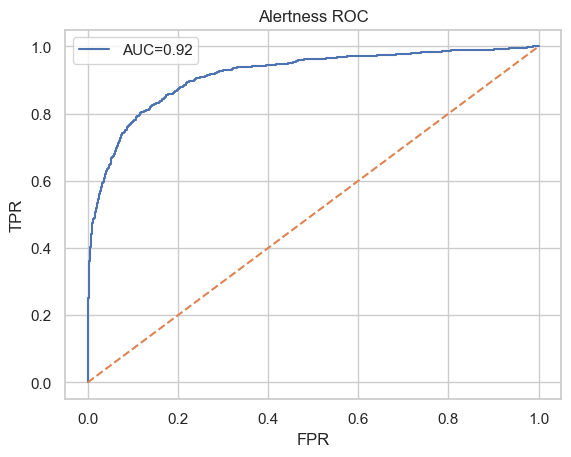

Alertness Macro F1: 0.818, Precision: 0.855, Recall: 0.795
Alertness Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92      2598
           1       0.83      0.64      0.72       913

    accuracy                           0.87      3511
   macro avg       0.86      0.80      0.82      3511
weighted avg       0.87      0.87      0.87      3511



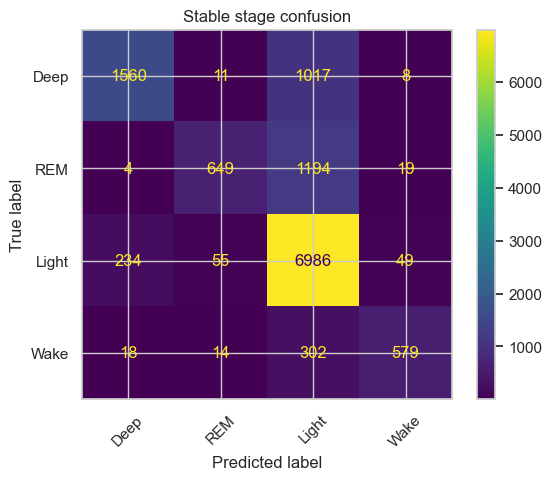

Stage Macro F1: 0.555, Precision: 0.674, Recall: 0.507
Stage Classification Report:
               precision    recall  f1-score   support

        Deep       0.86      0.60      0.71      2598
         REM       0.89      0.35      0.50      1868
       Light       0.74      0.95      0.83      7341
        Wake       0.88      0.63      0.74       913

   micro avg       0.77      0.77      0.77     12720
   macro avg       0.84      0.63      0.69     12720
weighted avg       0.79      0.77      0.75     12720



In [96]:

from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score, classification_report
# Alert ROC and metrics
fpr, tpr, _ = roc_curve(alert_df['y'], pipe_alert.predict_proba(alert_df[cols])[:,1])
y_pred_alert = pipe_alert.predict(alert_df[cols])
auc_score = roc_auc_score(alert_df['y'], pipe_alert.predict_proba(alert_df[cols])[:,1])
macro_f1 = f1_score(alert_df['y'], y_pred_alert, average='macro')
macro_precision = precision_score(alert_df['y'], y_pred_alert, average='macro')
macro_recall = recall_score(alert_df['y'], y_pred_alert, average='macro')
report = classification_report(alert_df['y'], y_pred_alert)
plt.plot(fpr, tpr, label=f'AUC={auc_score:.2f}')
plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Alertness ROC'); plt.legend(); plt.show()
print(f'Alertness Macro F1: {macro_f1:.3f}, Precision: {macro_precision:.3f}, Recall: {macro_recall:.3f}')
print('Alertness Classification Report:\n', report)

# Stage confusion and metrics
y_true_stage = epochs['stage']
y_pred_stage = epochs['stage_stable']
cm = confusion_matrix(y_true_stage, y_pred_stage, labels=STAGES)
ConfusionMatrixDisplay(cm, display_labels=STAGES).plot(xticks_rotation=45)
plt.title('Stable stage confusion'); plt.show()
macro_f1_stage = f1_score(y_true_stage, y_pred_stage, average='macro')
macro_precision_stage = precision_score(y_true_stage, y_pred_stage, average='macro', zero_division=0)
macro_recall_stage = recall_score(y_true_stage, y_pred_stage, average='macro', zero_division=0)
report_stage = classification_report(y_true_stage, y_pred_stage, labels=STAGES)
print(f'Stage Macro F1: {macro_f1_stage:.3f}, Precision: {macro_precision_stage:.3f}, Recall: {macro_recall_stage:.3f}')
print('Stage Classification Report:\n', report_stage)


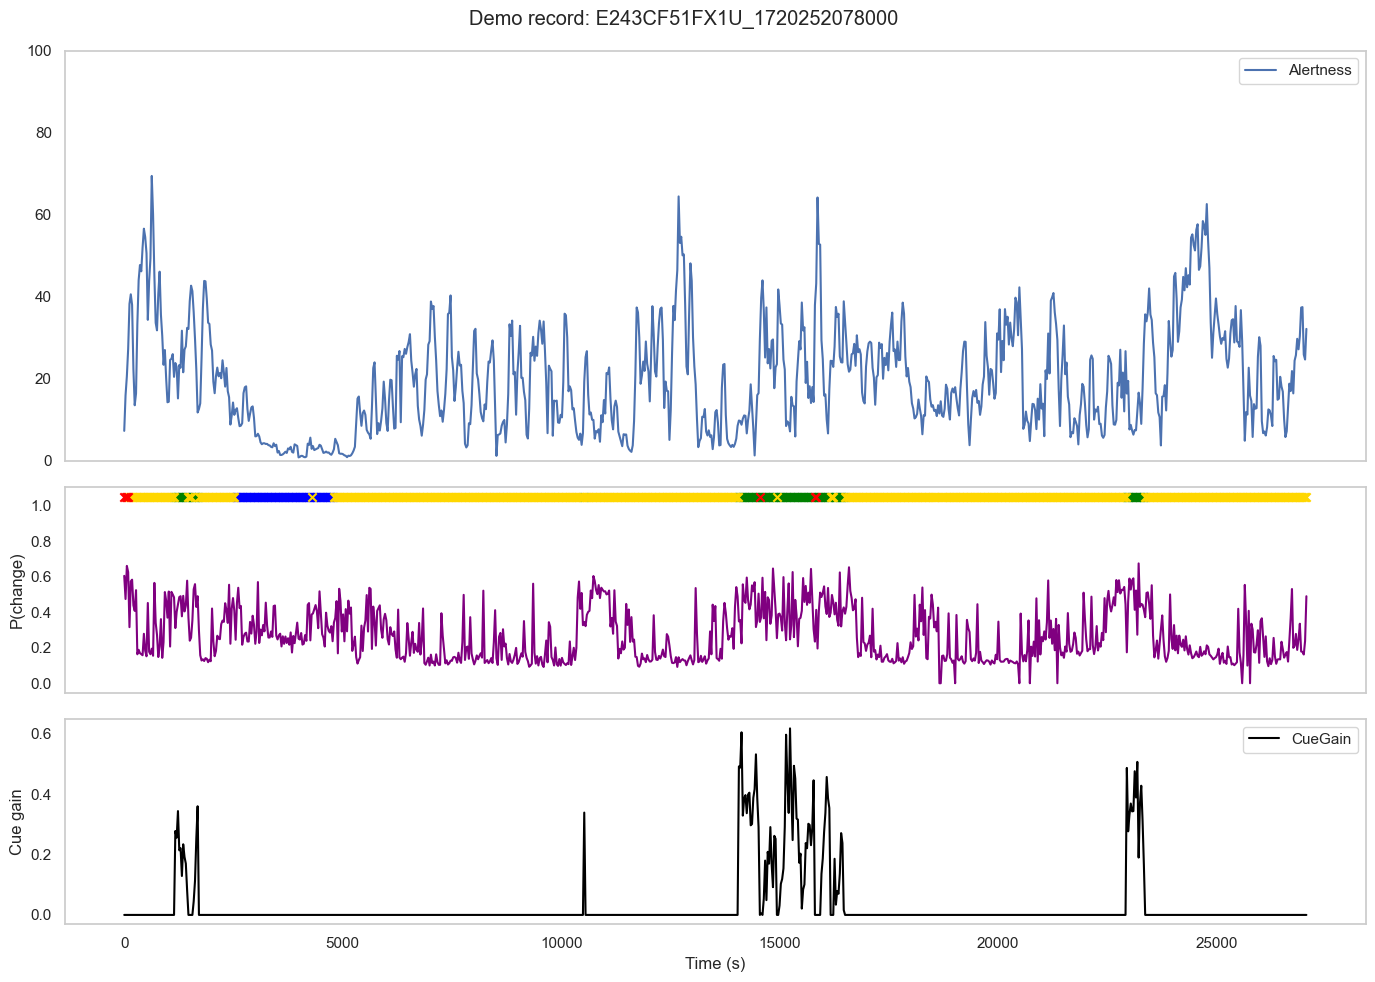

In [92]:

rec=epochs['record'].iloc[0]
samp=epochs[epochs['record']==rec].reset_index(drop=True)
t=np.arange(len(samp))*EPOCH_SEC
fig,(ax1,ax2,ax3)=plt.subplots(3,1,sharex=True,figsize=(14,10),
                               gridspec_kw={'height_ratios':[2,1,1]})
ax1.plot(t,samp['alert_smooth'],label='Alertness'); ax1.set_ylim(0,100); ax1.grid(); ax1.legend()
ax2.plot(t,samp['prob_change'],color='purple'); ax2.set_ylabel('P(change)'); ax2.grid()
colors={'Deep':'blue','REM':'green','Light':'gold','Wake':'red'}
for st,c in colors.items():
    mask=samp['stage_stable']==st
    ax2.scatter(t[mask],[1.05]*mask.sum(),c=c,marker='x')
ax3.plot(t,samp['cue_gain'],label='CueGain',color='black')
ax3.set_ylabel('Cue gain'); ax3.set_xlabel('Time (s)'); ax3.grid(); ax3.legend()
plt.suptitle(f'Demo record: {rec}'); plt.tight_layout(); plt.show()


In [93]:

with open('alertness_model.pkl','wb') as f: pickle.dump(pipe_alert,f)
with open('stage_model.pkl','wb') as f: pickle.dump(pipe_stage,f)
with open('config_thresholds.txt','w') as f:
    f.write(f'SMOOTH_WINDOW={SMOOTH_WINDOW}\nSTABLE_N={STABLE_N}\nCHANGE_THRESH={CHANGE_THRESH}\nCUE_ALERT_MAX={CUE_ALERT_MAX}')
print('Saved models and config.')


Saved models and config.


AUC (Wake vs Deep) — Raw: 0.916, Smooth: 0.943
Spearman Corr — Raw vs Stage: 0.437, Smooth vs Stage: 0.474
MSE — Raw: 1.160, Smooth: 1.353


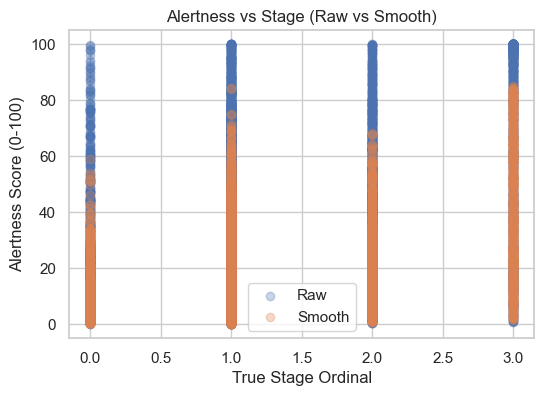

In [94]:
# --- Robust Performance Evaluation ---
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# Map sleep stages to ordinal for correlation/mse
ord_map = {'Deep': 0, 'REM': 2, 'Light': 1, 'Wake': 3}
epochs['stage_ord'] = epochs['stage'].map(ord_map)

# Filter rows where all needed columns are valid
df_eval = epochs.dropna(
    subset=['alert_raw', 'alert_smooth', 'stage', 'stage_ord']).copy()

# AUC for Wake vs Deep classification
wf = df_eval['stage'].isin(['Deep', 'Wake'])
df_wd = df_eval[wf].dropna(subset=['alert_raw', 'alert_smooth'])
y_true_wd = (df_wd['stage'] == 'Wake').astype(int)
raw_scores_wd = df_wd['alert_raw'] / 100
smooth_scores_wd = df_wd['alert_smooth'] / 100
auc_raw = roc_auc_score(y_true_wd, raw_scores_wd)
auc_smooth = roc_auc_score(y_true_wd, smooth_scores_wd)
print(f"AUC (Wake vs Deep) — Raw: {auc_raw:.3f}, Smooth: {auc_smooth:.3f}")

# Spearman correlation vs stage ordinal (skip NaNs)
valid_corr = df_eval.dropna(subset=['alert_raw', 'alert_smooth', 'stage_ord'])
corr_raw, _ = spearmanr(valid_corr['alert_raw'], valid_corr['stage_ord'])
corr_smooth, _ = spearmanr(valid_corr['alert_smooth'], valid_corr['stage_ord'])
print(
    f"Spearman Corr — Raw vs Stage: {corr_raw:.3f}, Smooth vs Stage: {corr_smooth:.3f}")

# MSE for ordinal prediction (NaNs removed)
mse_raw = mean_squared_error(
    valid_corr['stage_ord'], valid_corr['alert_raw'] / 100)
mse_smooth = mean_squared_error(
    valid_corr['stage_ord'], valid_corr['alert_smooth'] / 100)
print(f"MSE — Raw: {mse_raw:.3f}, Smooth: {mse_smooth:.3f}")

# Scatter plot: alertness vs stage ordinal
plt.figure(figsize=(6, 4))
plt.scatter(valid_corr['stage_ord'],
            valid_corr['alert_raw'], alpha=0.3, label='Raw')
plt.scatter(valid_corr['stage_ord'],
            valid_corr['alert_smooth'], alpha=0.3, label='Smooth')
plt.xlabel('True Stage Ordinal')
plt.ylabel('Alertness Score (0-100)')
plt.title('Alertness vs Stage (Raw vs Smooth)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

stage_colors = {'Deep': '#4F81BD', 'REM': '#9BBB59',
                'Light': '#FCD116', 'Wake': '#C0504D'}
stages = ['Deep', 'REM', 'Light', 'Wake']


def plot_session_diagnostics(samp, title_prefix=''):
    t = np.arange(len(samp)) * EPOCH_SEC
    split = samp['split'].iloc[0] if 'split' in samp.columns else 'unknown'

    fig = plt.figure(figsize=(16, 12), facecolor='#f9f9f9' if split ==
                     'train' else '#fffbea' if split == 'val' else '#fef2f2')
    gs = gridspec.GridSpec(5, 1, height_ratios=[0.8, 0.8, 1.0, 1.0, 1.0])

    def label_split(split):
        return {'train': 'TRAIN', 'test': 'TEST', 'val': 'VALIDATION', 'unknown': 'UNLABELED'}.get(split, split.upper())

    # 1. Ground truth
    ax1 = plt.subplot(gs[0])
    for stage in stages:
        for x in t[samp['stage'] == stage]:
            ax1.barh(stage, EPOCH_SEC, left=x,
                     color=stage_colors[stage], edgecolor='none')
    ax1.set_xlim(t[0], t[-1] + EPOCH_SEC)
    ax1.set_yticks(stages)
    ax1.set_title(f"{title_prefix} Ground Truth Stage – {label_split(split)}")
    ax1.set_xticks([])
    ax1.grid(True, axis='x', linestyle='--', alpha=0.3)

    # 2. Predicted stable stage
    ax2 = plt.subplot(gs[1])
    for stage in stages:
        for x in t[samp['stage_stable'] == stage]:
            ax2.barh(stage, EPOCH_SEC, left=x,
                     color=stage_colors[stage], edgecolor='none')
    ax2.set_xlim(t[0], t[-1] + EPOCH_SEC)
    ax2.set_yticks(stages)
    ax2.set_title(f"{title_prefix} Predicted Stage (Stable)")
    ax2.set_xticks([])
    ax2.grid(True, axis='x', linestyle='--', alpha=0.3)

    # 3. Alertness
    ax3 = plt.subplot(gs[2])
    ax3.plot(t, samp['alert_smooth'], label='Alertness',
             color='royalblue', linewidth=2)
    ax3.set_ylabel('Alertness')
    ax3.set_ylim(0, 100)
    ax3.set_title('Alertness Over Time')
    ax3.grid(True)
    ax3.legend(loc='upper right')

    # 4. Probability of change
    ax4 = plt.subplot(gs[3])
    ax4.plot(t, samp['prob_change'], label='P(change)',
             color='purple', linewidth=2, linestyle='--')
    ax4.set_ylabel('Prob change')
    ax4.set_ylim(0, 1.05)
    ax4.set_title('Probability of Change Over Time')
    ax4.grid(True)
    ax4.legend(loc='upper right')

    # 5. Cue gain
    ax5 = plt.subplot(gs[4])
    ax5.plot(t, samp['cue_gain'], label='CueGain', color='black', linewidth=2)
    for x in t[samp['stage_stable'] == 'REM']:
        ax5.axvspan(x, x + EPOCH_SEC, color=stage_colors['REM'], alpha=0.1)
    ax5.set_ylabel('Cue gain')
    ax5.set_xlabel('Time (s)')
    ax5.set_ylim(0, 1.05)
    ax5.set_title('Cue Gain Over Time (REM Highlighted)')
    ax5.grid(True)
    ax5.legend(loc='upper right')

    plt.suptitle(
        f"Session: {title_prefix.strip()} | Split: {label_split(split)}", fontsize=13, weight='bold')
    plt.tight_layout()
    plt.show()


# Loop through all records
for rec in epochs['record'].unique():
    sample = epochs[epochs['record'] == rec].reset_index(drop=True)
    plot_session_diagnostics(sample, title_prefix=f"Session {rec}")